In [125]:
!nvidia-smi

Wed Oct  8 13:04:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 8000                On  |   00000000:73:00.0 Off |                  Off |
| 33%   54C    P5             43W /  260W |     793MiB /  49152MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Laminography demo (CIL): FBP vs FISTA on centre slice

Dataset: `data/lamino_demo_cil.nxs`  
Pipeline: load → visualise → flat/dark normalise → transmission→absorption → build 30 degree lamino geometry (COR=0) → ASTRA FBP and FISTA(TV) → compare centre slice.


In [126]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionGeometry, AcquisitionData, ImageGeometry, ImageData
from cil.utilities.display import show2D, show_geometry
from cil.processors import Normaliser, TransmissionAbsorptionConverter, Padder

import numpy as np
import ipywidgets as W
from cil.utilities.jupyter import islicer, link_islicer

BACKEND = None
try:
    from cil.plugins.astra import FBP as AstraFBP
    from cil.plugins.astra import ProjectionOperator as AstraPO
    BACKEND = 'astra'
except:
    print("Unable to load ASTRA, please install again")
    BACKEND = None
print("Backend:", BACKEND)


Backend: astra


In [127]:
# File and dataset keys
DATA_PATH      = "data/lamino_demo_cil.nxs"
PROJ_KEY       = "/entry/imaging/data"
ANGLES_KEY     = "/entry/imaging_sum/smaract_zrot_value_set"   
IMAGE_KEY_PATH = "/entry/instrument/EtherCAT/image_key"        

# Geometry
TILT_DEG        = 30.0
PIXEL_SIZE_UM   = 0.54      # microns
DETECTOR_POS_UM = [0, 500, 0]   # purely to draw a nice geometry; not critical in Parallel3D

# FISTA settings
FISTA_ITERS = 25
TV_WEIGHT   = 0.002


raw stack: (532, 256, 256) angles: (532,)
proj: (512, 256, 256) flats: (10, 256, 256) darks: (10, 256, 256)
angles_proj: (512,)


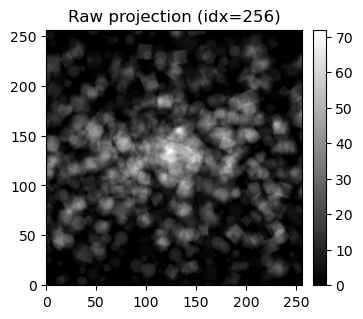

In [128]:
# Raw arrays from NeXus
import numpy as np
from cil.io.utilities import HDF5_utilities

# Load
data_all  = HDF5_utilities.read(DATA_PATH, PROJ_KEY)              # (N, V, H)
angles    = HDF5_utilities.read(DATA_PATH, ANGLES_KEY)            # shape (N,)
try:
    image_key = HDF5_utilities.read(DATA_PATH, IMAGE_KEY_PATH)    # 0=proj,1=flat,2=dark
except Exception:
    image_key = None

print("raw stack:", data_all.shape, "angles:", angles.shape if angles is not None else None)

# Split by image_key
if image_key is None:
    proj  = data_all
    flats = np.empty((0, *data_all.shape[1:]), dtype=data_all.dtype)
    darks = np.empty_like(flats)
    angles_proj = angles
else:
    image_key   = np.asarray(image_key, dtype=int)
    proj_mask   = (image_key == 0)
    flat_mask   = (image_key == 1)
    dark_mask   = (image_key == 2)

    proj  = data_all[proj_mask]
    flats = data_all[flat_mask]
    darks = data_all[dark_mask]
    angles_proj = angles[proj_mask] if angles is not None else None

print("proj:", proj.shape, "flats:", flats.shape, "darks:", darks.shape)
if angles_proj is not None:
    print("angles_proj:", angles_proj.shape)

# Ensure angles are degrees, match projection count
def _ensure_degrees(a):
    a = np.asarray(a, dtype=np.float64)
    return np.degrees(a) if np.nanmax(np.abs(a)) < 7.0 else a

if angles_proj is None:
    angles_proj = np.linspace(0.0, 360.0, proj.shape[0], endpoint=False, dtype=np.float32)
else:
    angles_proj = _ensure_degrees(angles_proj).astype(np.float32)

assert angles_proj.shape[0] == proj.shape[0], (
    f"Angles/projections mismatch: {angles_proj.shape[0]} vs {proj.shape[0]}"
)

# Show a single projection
from cil.utilities.display import show2D
idx = proj.shape[0] // 2  # choose the middle projection
show2D([proj[idx]], title=[f'Raw projection (idx={idx})'], cmap='gray', fix_range=True, num_cols=1, size=(6,6))

# --- islicer ---
# p_lo, p_hi = np.percentile(proj, [0.5, 99.5])
# w = islicer(proj, direction=0, title=f"Raw projections (N={proj.shape[0]})",
#             cmap="gray", minmax=(float(p_lo), float(p_hi)), size=10,
#             axis_labels=["angle","vertical","horizontal"], slice_number=idx)
# w


In [129]:
# Build acquisition geometry (laminography) with COR=0 and 30 degree tilt
N, V, H = proj.shape
tilt = np.radians(TILT_DEG)

ag = AcquisitionGeometry.create_Parallel3D(
    rotation_axis_direction=[0, -np.sin(tilt),  np.cos(tilt)],  
    rotation_axis_position=[0, 0, 0],                          
    detector_position=DETECTOR_POS_UM,
    units="microns"
)
ag.set_panel(num_pixels=[H, V], pixel_size=PIXEL_SIZE_UM, origin='top-left')
ag.set_angles(angles_proj, angle_unit='degree')
ag.set_labels(['angle','vertical','horizontal'])

acq = AcquisitionData(array=proj, geometry=ag)

# Flat/dark normalisation
flat_avg = flats.mean(axis=0) if flats.size else None
dark_avg = darks.mean(axis=0) if darks.size else None
if flat_avg is not None and dark_avg is not None:
    acq = Normaliser(flat_field=flat_avg, dark_field=dark_avg)(acq)

# Transmission -> Absorption
# acq = TransmissionAbsorptionConverter(min_intensity=1e-6)(acq) # disabled for my crappy simulated data

# Display
import ipywidgets as W
from IPython.display import display
from cil.utilities.display import show_geometry

corr = acq.as_array()[idx]

left  = W.Output()
right = W.Output()

with left:
    show2D([proj[idx], corr],
           title=[f'Raw (idx={idx})', 'Normalised + absorption'],
           cmap='gray', fix_range=True, num_cols=2, size=(12,5))
with right:
    show_geometry(acq.geometry)

display(W.HBox([left, right], layout=W.Layout(gap="16px")))


In [130]:
# Choose reconstruction grid before padding (keep ROI grid)
ig = acq.geometry.get_ImageGeometry()
print("Chosen image grid:", ig)


Chosen image grid: Number of channels: 1
channel_spacing: 1.0
voxel_num : x256,y256,z256
voxel_size : x0.54,y0.54,z0.54
center : x0,y0,z0



Original acquisition shape: (512, 256, 256)    Padded shape: (512, 456, 456)


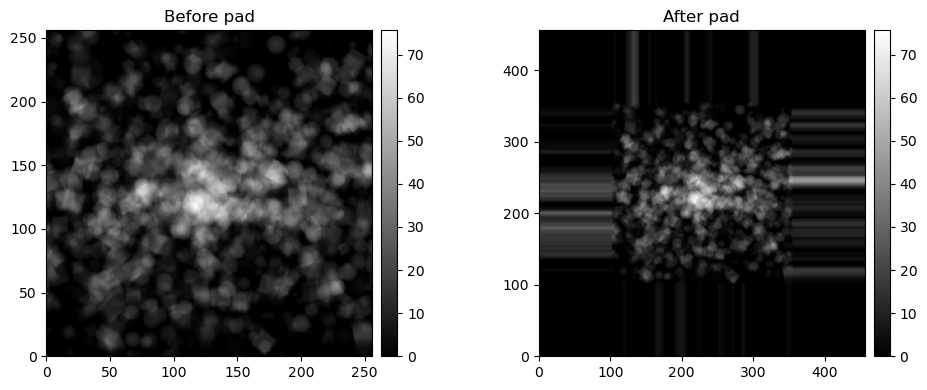

In [131]:
# ROI compensation with padding

PADSIZE = 100  

acq_pad = Padder.edge(pad_width={'horizontal': PADSIZE, 'vertical': PADSIZE})(acq)

print("Original acquisition shape:", acq.shape, "   Padded shape:", acq_pad.shape)
# Quick visual: first projection before/after
show2D([acq.as_array()[0], acq_pad.as_array()[0]], title=['Before pad', 'After pad'],
       cmap='gray', fix_range=True, num_cols=2, size=(10,4))


In [132]:
# Reorder for astra
if BACKEND == 'astra':
    acq_pad.reorder('astra')
    print("Reordered for ASTRA ->", acq_pad.shape)
print(ig)


Reordered for ASTRA -> (456, 512, 456)
Number of channels: 1
channel_spacing: 1.0
voxel_num : x256,y256,z256
voxel_size : x0.54,y0.54,z0.54
center : x0,y0,z0



In [133]:
fbp = AstraFBP(image_geometry=ig, acquisition_geometry=acq_pad.geometry)
fbp.set_input(acq_pad)
recon_fbp = fbp.get_output()
print("FBP volume:", recon_fbp.shape)


FBP volume: (256, 256, 256)


In [134]:
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares, TotalVariation

A = AstraPO(image_geometry=ig, acquisition_geometry=acq_pad.geometry)

f_data = LeastSquares(A, b=acq_pad, c=0.5)
g_tv   = TV_WEIGHT * TotalVariation()

algo = FISTA(initial=ig.allocate(0.0), f=f_data, g=g_tv)
algo.max_iteration = FISTA_ITERS
algo.run(iterations=FISTA_ITERS, verbose=2)

recon_fista = algo.solution
print("FISTA volume:", recon_fista.shape)


  0%|          | 0/25 [00:00<?, ?it/s]

FISTA volume: (256, 256, 256)


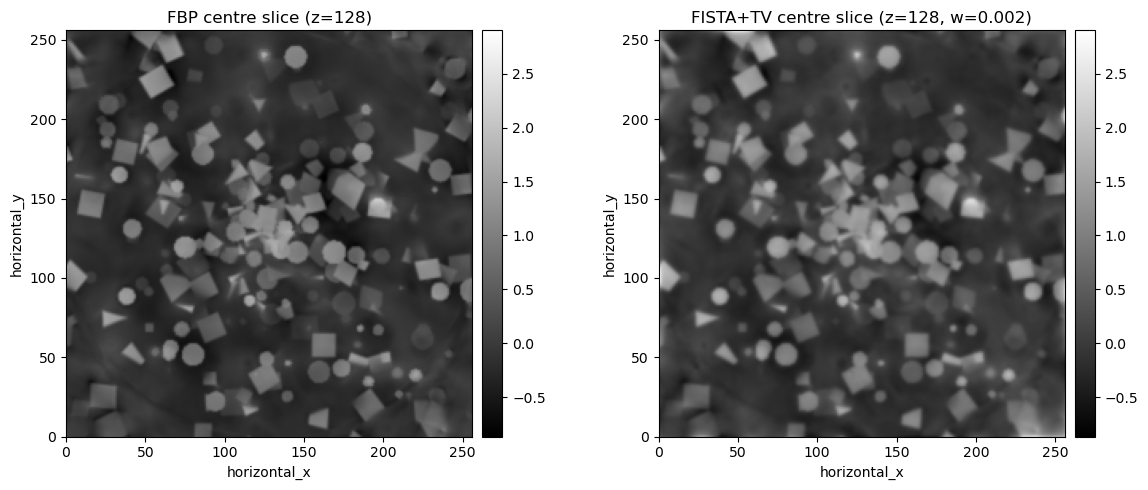

In [135]:
z = recon_fbp.shape[0] // 2
fbp_mid   = recon_fbp.get_slice(vertical=z)
fista_mid = recon_fista.get_slice(vertical=z)

show2D([fbp_mid, fista_mid],
       title=[f"FBP centre slice (z={z})", f"FISTA+TV centre slice (z={z}, w={TV_WEIGHT})"],
       cmap='gray', fix_range=True, num_cols=2, size=(12,5))


In [136]:
# # Interactive linked slicers for FBP vs FISTA
# import numpy as np
# import ipywidgets as W
# from cil.utilities.jupyter import islicer, link_islicer

# arr_fbp   = recon_fbp.as_array().astype(np.float32)
# arr_fista = recon_fista.as_array().astype(np.float32)
# lo = np.percentile(np.concatenate([arr_fbp.ravel(), arr_fista.ravel()]), 0.5)
# hi = np.percentile(np.concatenate([arr_fbp.ravel(), arr_fista.ravel()]), 99.5)

# # Slice along Z (axis 0)
# w_fbp   = islicer(recon_fbp,   direction=0, title="FBP (Z slices)",
#                   cmap="gray", minmax=(lo, hi), size=8, axis_labels=["Z","Y","X"])
# w_fista = islicer(recon_fista, direction=0, title=f"FISTA+TV (Z slices, w={TV_WEIGHT})",
#                   cmap="gray", minmax=(lo, hi), size=8, axis_labels=["Z","Y","X"])

# # Link the sliders so they stay on the same slice index
# link_islicer(w_fbp, w_fista)
# W.VBox([w_fbp, w_fista])
